In [5]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

In [7]:
import pandas_datareader.data as web

In [8]:
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [9]:
import seaborn as sns
import talib

In [10]:
from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [1]:
class DataPrep:
    
    def __init__(self,ticker,batch="train", source='assets.h5', destination='data.h5', data_type='prices' ):
        self.source = source
        self.ticker = ticker
        self.path = 'yfinance/{}/{}/{}'.format(data_type,batch,ticker.lower())
        self.destination = destination
        self.dest_path = 'model_data/{}/{}'.format(batch,ticker)
        
    def extract_data(self):
        with pd.HDFStore('assets.h5') as store:
            data = (store[self.path]
                    .dropna()
                    .drop(['Close'], axis = 1))
        return data
    
    def _compute_bb(self,close):
        high, mid, low = BBANDS(close, timeperiod=20)
        return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)
    
    def _compute_atr(self,price_data):
        df = ATR(price_data.high, price_data.low, 
                 price_data.close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    
    def _compute_macd(self,close):
        macd = MACD(close)[0]
        return (macd - np.mean(macd))/np.std(macd)
            
    def transform_data(self, frame=None):
        
            
            frame_tr = frame.rename(columns ={ "Open": "open",
                                                "High": "high",
                                                "Low" : "low",
                                               "Adj Close" : "close",
                                               "Volume" : "volume"})
            
            lags = [1, 5, 10, 21, 42, 63]
            periods = [5,21,63]
            
                # trends indicators
            
            for t in periods:
                frame_tr[f'SMA_{t}'] = talib.SMA(frame_tr.close, timeperiod = t)
                
             #lagged returns
            for lag in lags:
                frame_tr['return_{}d'.format(lag)] = np.log(frame_tr.close/frame_tr.close.shift(lag))
            
                #overlap studies
            
            frame_tr['HT_TRENDLINE'] = talib.HT_TRENDLINE(frame_tr.close)
            
            #Bollinger bands
            
            frame_tr = frame_tr.join(frame_tr.close.transform(self._compute_bb))
            frame_tr['BB_HIGH'] = frame_tr.bb_high.sub(frame_tr.close).div(frame_tr.bb_high).apply(np.log1p)
            frame_tr['BB_LOW'] = frame_tr.close.sub(frame_tr.bb_low).div(frame_tr.close).apply(np.log1p)
            
            
                #Momentum indicators 
            
            #RSI
            frame_tr['RSI'] = frame_tr.close.transform(RSI)
            
            
            #moving average convergence/divergence
            
            frame_tr['MACD'] = self._compute_macd(frame_tr.close)
            
            # Plus/minus directional index
            
            frame_tr['PLUS_DM'] = talib.PLUS_DM(frame_tr.high, frame_tr.low, timeperiod=10)
            frame_tr['MINUS_DM'] = talib.MINUS_DM(frame_tr.high, frame_tr.low,timeperiod=10)
            
            # Average directional movement index
            
            frame_tr['ADX'] = talib.ADX(frame_tr.high, frame_tr.low, frame_tr.close, timeperiod=14)
            
            
            # percentage price oscillator(PPO)
            frame_tr['PPO'] = talib.PPO(frame_tr.close, fastperiod = 12, slowperiod=26, matype=0)
            
            # stochastic oscillator
            
            slowk, slowd = talib.STOCH(frame_tr.high,
                           frame_tr.low,
                           frame_tr.close,
                           fastk_period=14,
                           slowk_period=3,
                           slowk_matype=0,
                           slowd_period=3,
                           slowd_matype=0)
            frame_tr['STOCH'] = slowd / slowk
            
            
            # Money flow index
            frame_tr['MFI'] = talib.MFI(frame_tr.high,frame_tr.low, frame_tr.close,
                                       frame_tr.volume, timeperiod =14)
            
                #volume indicators
            
            #chaikin A/D line
            
            frame_tr['AD'] = talib.AD(frame_tr.high,
                       frame_tr.low,
                       frame_tr.close,
                       frame_tr.volume)
            
                #volatility indicators
                
            # average true range
            
            frame_tr['ATR'] = self._compute_atr(frame_tr)
            
           
            #forward returns
            
            for t in [1]:
                frame_tr[f'target_{t}d'] = frame_tr[f'return_{t}d'].shift(-t)
                   
        
            frame_tr.dropna(inplace = True)
            
            frame_tr.to_hdf(self.destination, self.dest_path )
            
            print("transformed {} can be found in {} under {}".format(self.ticker, self.destination, self.dest_path))
            
            return frame_tr
        
    def extract_transform(self):
        
        e = self.extract_data()
        return self.transform_data(e)
    

In [11]:
ticker = 'msft'

In [12]:
p = DataPrep(ticker,batch='train')

In [13]:
f = p.extract_transform()

transformed msft can be found in data.h5 under model_data/train/msft


In [14]:
test = DataPrep(ticker, batch="test")
test.extract_transform()

transformed msft can be found in data.h5 under model_data/test/msft


,open,high,low,close,volume,SMA_5,SMA_21,SMA_63,return_1d,return_5d,...,MACD,PLUS_DM,MINUS_DM,ADX,PPO,STOCH,MFI,AD,ATR,target_1d
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-02,151.860001,155.479996,150.360001,150.975189,49630700,150.724295,146.124742,159.414619,0.020497,-0.005460,...,-0.757285,21.277073,17.262219,22.326844,-3.036669,1.080124,57.694991,-5.909563e+09,2.381442,-0.009253
2020-04-03,155.100006,157.380005,152.190002,149.584641,41243300,151.527502,145.548710,159.347355,-0.009253,0.027215,...,-0.684002,21.049375,15.535997,21.297686,-2.199451,1.095936,64.437690,-5.992214e+09,2.127951,0.071733
2020-04-06,160.320007,166.500000,157.580002,160.708939,67111700,152.507687,145.720038,159.450356,0.071733,0.030970,...,-0.409548,28.064433,13.982397,21.386954,-1.052185,0.898488,64.279050,-6.012244e+09,2.489044,-0.010829
2020-04-07,169.589996,170.000000,163.259995,158.978073,62769000,153.631787,146.315983,159.548202,-0.010829,0.035994,...,-0.224803,28.757989,12.584157,21.810714,0.604822,0.899870,71.998575,-6.154767e+09,2.391663,0.009981
2020-04-08,165.669998,166.669998,163.500000,160.572754,48318200,156.163919,146.510925,159.632725,0.009981,0.082129,...,-0.049278,25.882190,11.325742,22.204205,2.178422,0.916396,65.381628,-6.292321e+09,2.210486,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,241.259995,241.990005,233.869995,237.594894,28651700,241.307593,246.988033,238.908200,-0.025860,-0.044424,...,-0.097691,15.575511,21.644335,13.578269,0.110817,0.894270,35.283144,-3.684192e+10,-0.676996,0.002265
2022-12-23,236.110001,238.869995,233.940002,238.133545,21207000,240.118570,246.567657,238.939032,0.002265,-0.024659,...,-0.227208,14.017960,19.479902,13.249776,-0.033003,0.898924,35.554680,-3.682705e+10,-0.795723,-0.007442
2022-12-27,238.699997,238.929993,235.830002,236.367981,16688600,239.422318,246.067482,238.958260,-0.007442,-0.014621,...,-0.361702,12.676161,17.531912,12.934218,-0.312552,1.214151,39.733903,-3.683795e+10,-1.009824,-0.010308


In [15]:
f

,open,high,low,close,volume,SMA_5,SMA_21,SMA_63,return_1d,return_5d,...,MACD,PLUS_DM,MINUS_DM,ADX,PPO,STOCH,MFI,AD,ATR,target_1d
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-06,29.150000,29.580000,28.980000,22.484381,47366800,22.516593,22.550848,22.366550,0.001707,-0.009167,...,-0.382126,0.933224,0.974927,23.139446,1.053196,1.085308,51.590223,-9.827324e+10,2.501942,0.001023
2010-04-07,29.160000,29.559999,29.139999,22.507393,58318800,22.452176,22.577140,22.348707,0.001023,-0.014209,...,-0.396279,0.839902,0.877435,21.676638,0.941050,1.042369,52.091055,-1.001735e+11,2.500066,0.019235
2010-04-08,29.320000,29.980000,29.299999,22.944502,63713800,22.548801,22.618039,22.340104,0.019235,0.021281,...,-0.359830,1.175912,0.789691,21.403191,0.838701,1.021250,59.381219,-1.014282e+11,2.559437,0.013940
2010-04-09,29.950001,30.410000,29.900000,23.266584,54752500,22.729780,22.668068,22.340490,0.013940,0.039669,...,-0.296936,1.488321,0.710722,22.010602,0.721071,1.040114,57.918801,-1.029072e+11,2.613473,-0.000660
2010-04-12,30.250000,30.490000,30.209999,23.251244,37068800,22.890821,22.709697,22.338088,-0.000660,0.035244,...,-0.251543,1.419489,0.639650,22.717661,0.688368,1.046143,63.254174,-1.047868e+11,2.626383,0.004279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,157.350006,158.490005,156.289993,152.648926,53477500,150.837415,147.591405,140.500439,0.010859,0.018466,...,2.893711,7.130039,2.609435,29.299369,1.196021,0.922085,72.732702,-1.857212e+12,-0.390303,0.000000
2019-12-23,158.119995,158.119995,157.270004,152.648926,17718200,151.202042,147.957605,140.815931,0.000000,0.012015,...,3.021169,6.417035,2.348491,30.162920,1.353822,0.944086,79.506976,-1.857423e+12,-0.432595,-0.000191
2019-12-24,157.479996,157.710007,157.119995,152.619812,8989200,151.723767,148.317339,141.100585,-0.000191,0.017240,...,3.077803,5.775332,2.263651,30.834797,1.459184,1.054963,76.067095,-1.857569e+12,-0.534979,0.008163


In [16]:
ohlcv = ['open', 'high', 'low', 'close', 'volume']

In [17]:
f.drop(ohlcv, axis = 1, inplace = True)

In [18]:
f.columns

Index(['SMA_5', 'SMA_21', 'SMA_63', 'return_1d', 'return_5d', 'return_10d',
       'return_21d', 'return_42d', 'return_63d', 'HT_TRENDLINE', 'bb_high',
       'bb_low', 'BB_HIGH', 'BB_LOW', 'RSI', 'MACD', 'PLUS_DM', 'MINUS_DM',
       'ADX', 'PPO', 'STOCH', 'MFI', 'AD', 'ATR', 'target_1d'],
      dtype='object')

In [19]:
corr_mat = f.drop('target_1d', axis =1).corr(method='spearman')

<Axes: >

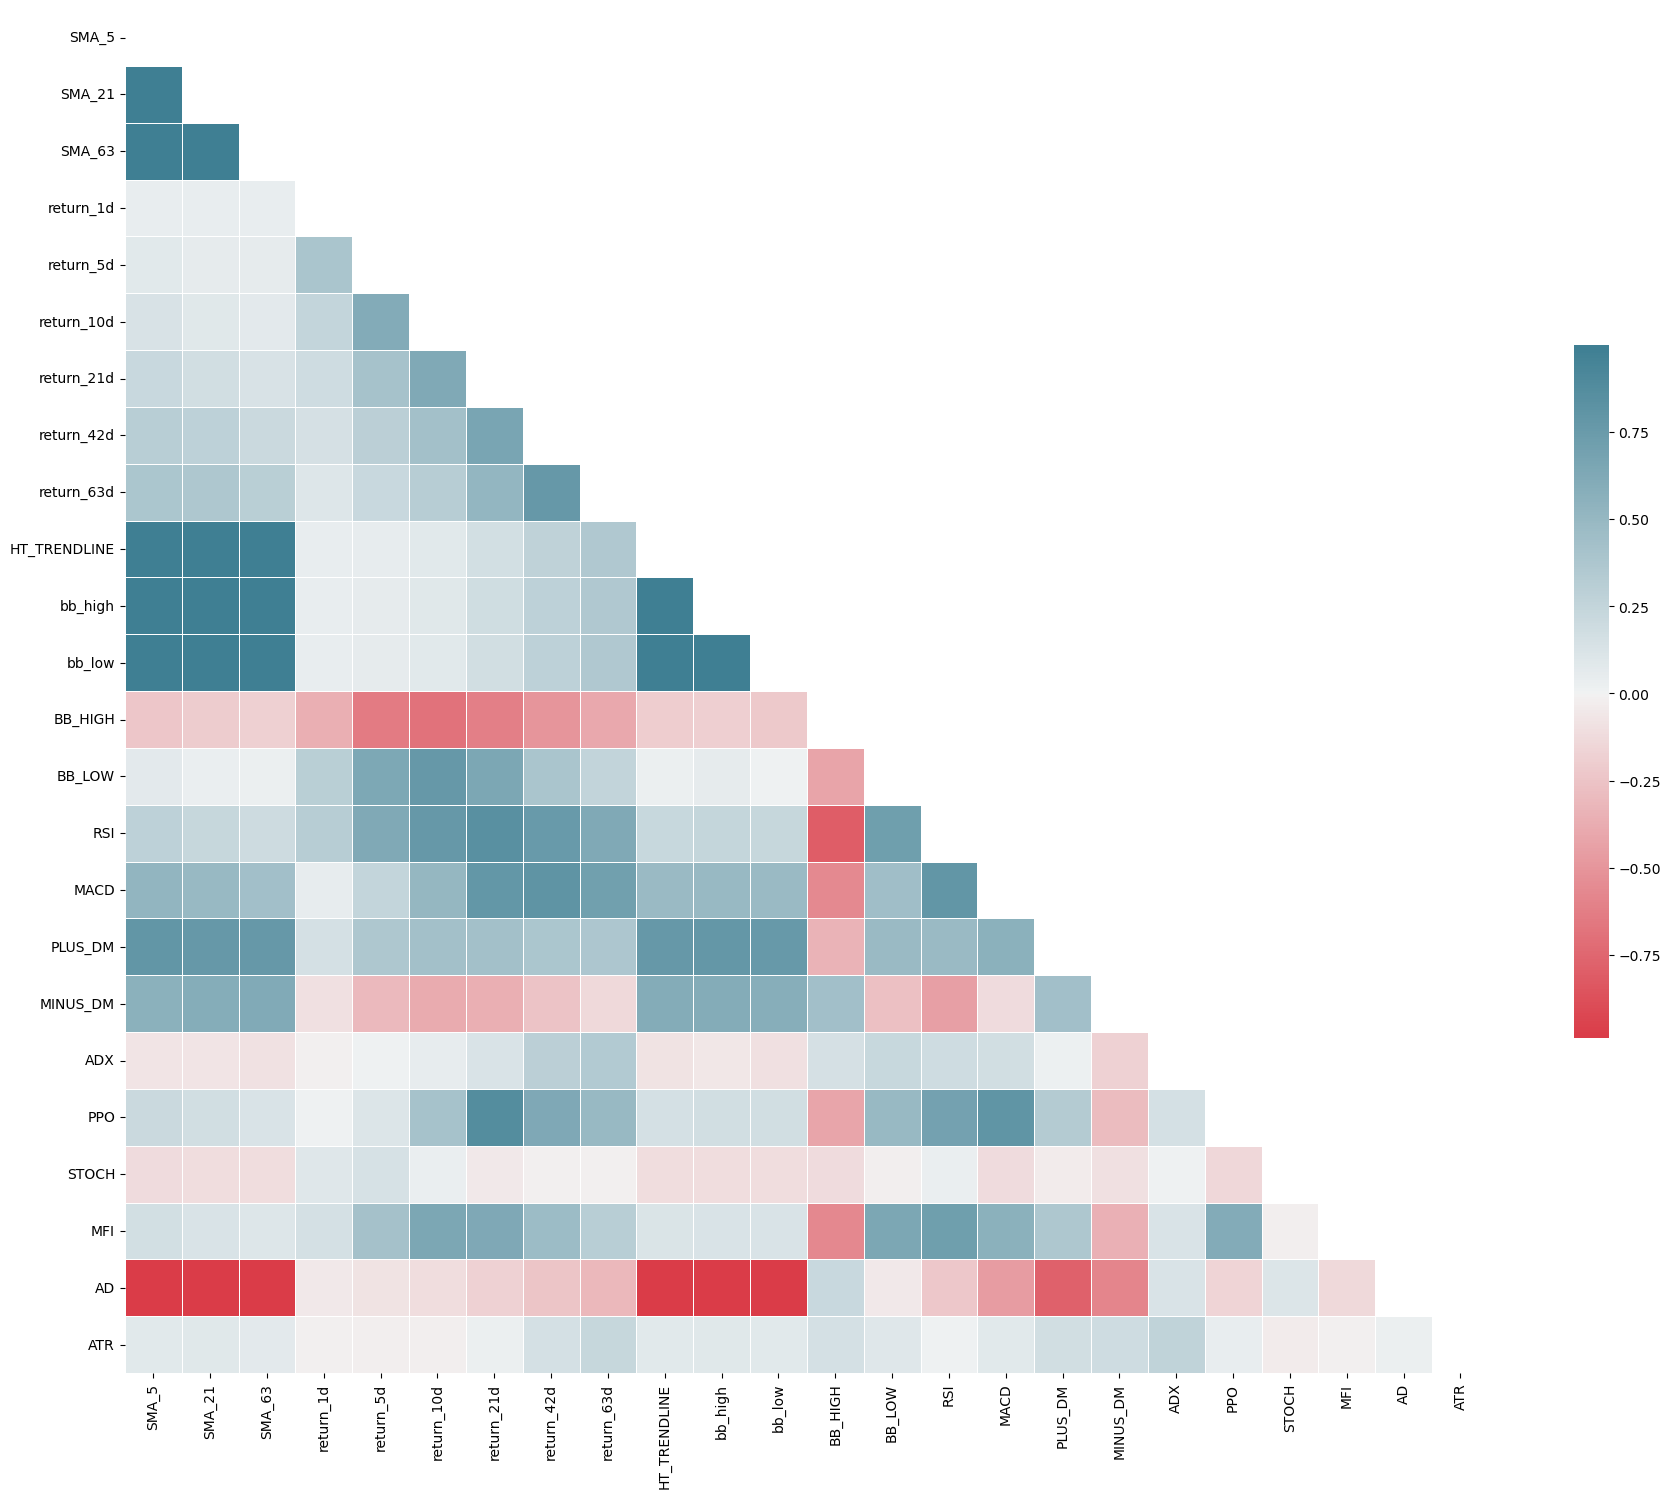

In [20]:
fig, ax = plt.subplots(figsize=(22, 18))
mask = np.triu(np.ones_like(corr_mat,dtype=bool))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr_mat,mask=mask, cmap=cmap, center = 0, square=True,
           linewidths = .5, cbar_kws={"shrink" : .5})
#fig.tight_layout()

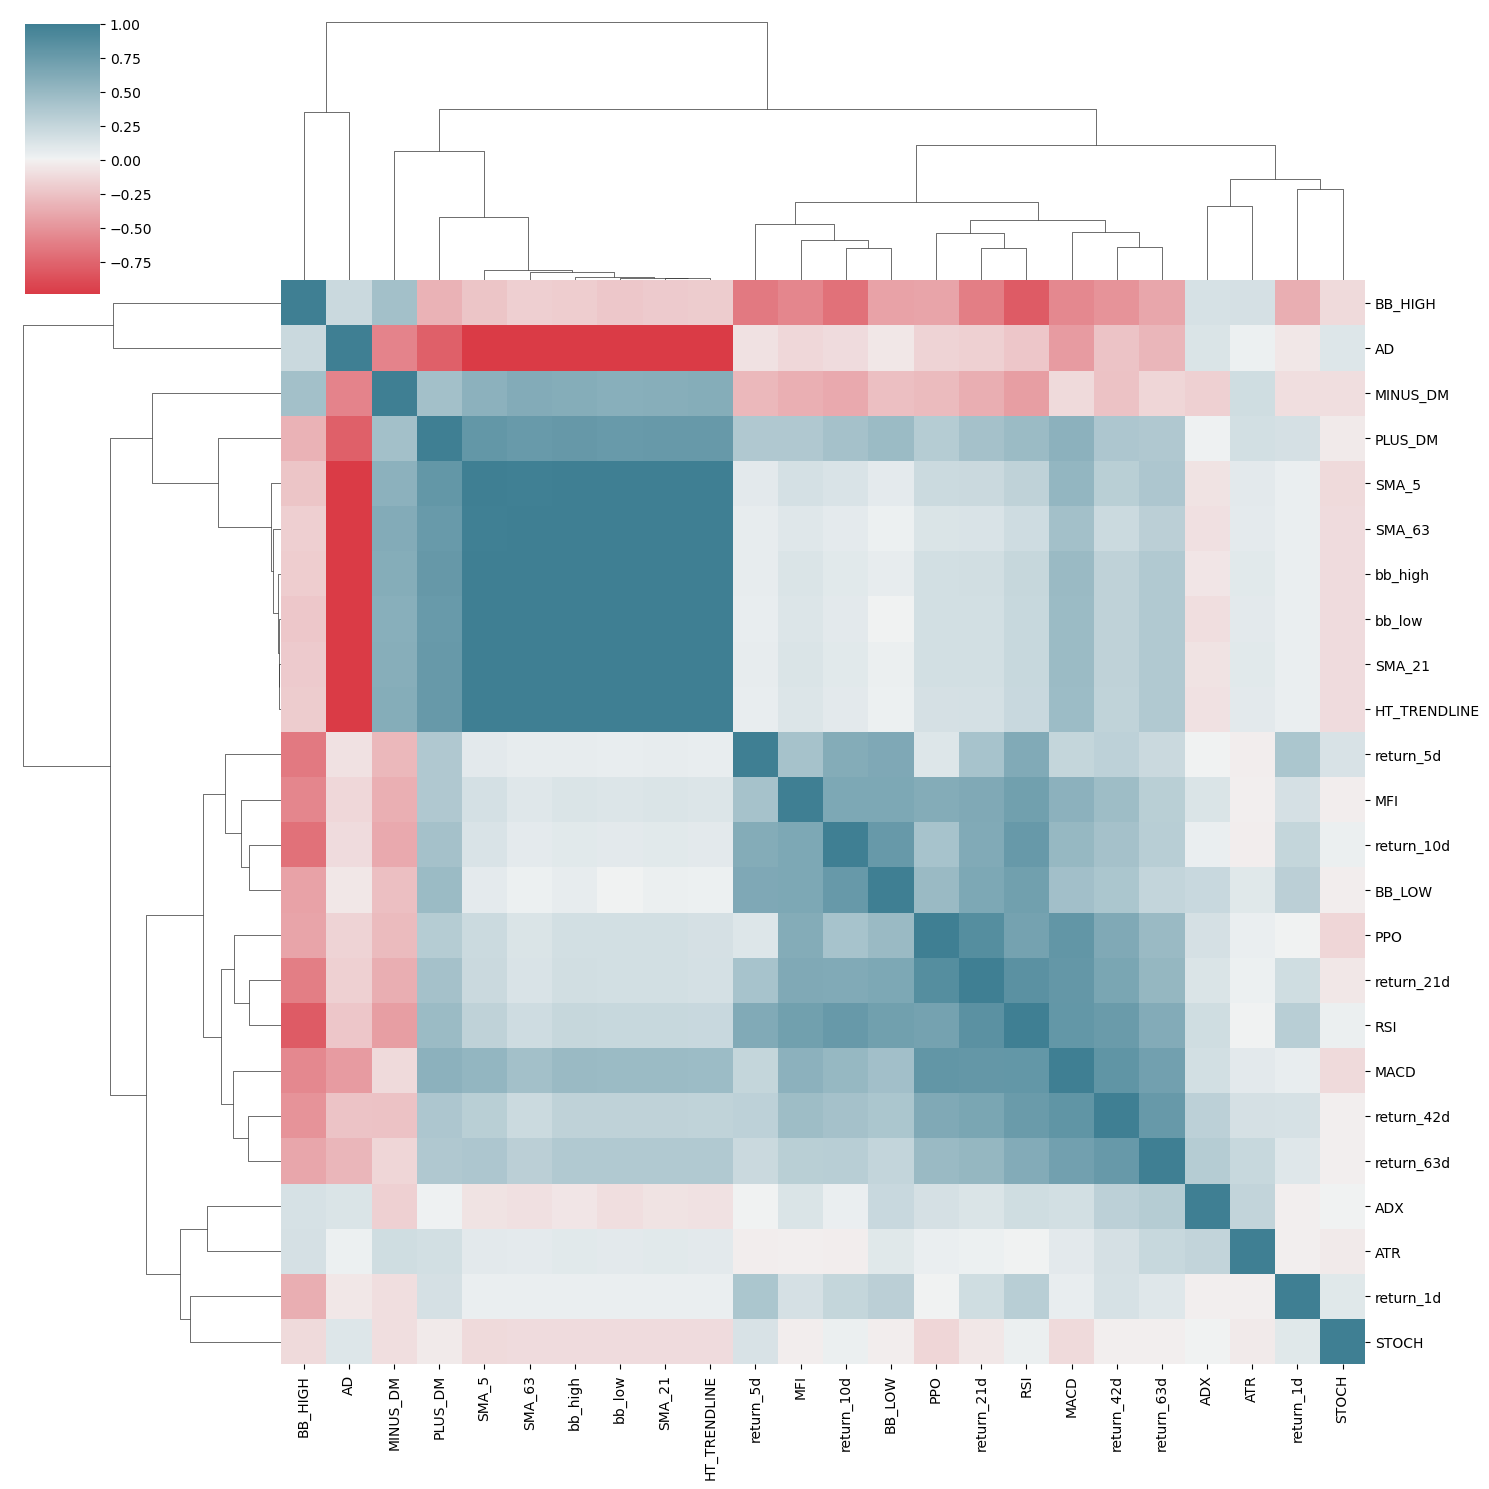

In [21]:
g = sns.clustermap(corr_mat, cmap=cmap, figsize=(15, 15))

## Forward return correlation

In [22]:
fwd_corr = f.drop(['target_1d'], axis = 1).corrwith(f.target_1d, method='spearman')

In [23]:
fwd_corr = fwd_corr.dropna()

<Axes: >

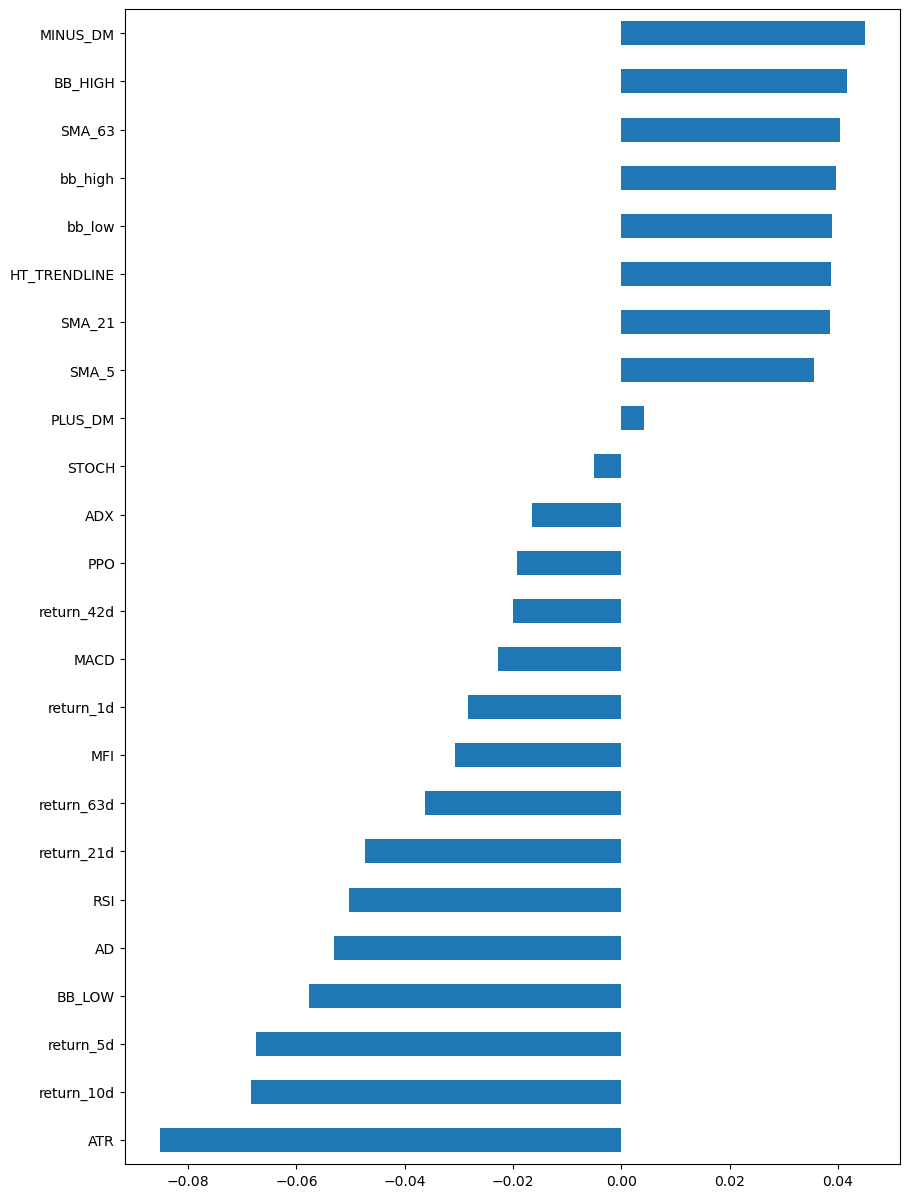

In [24]:
fwd_corr.sort_values().plot.barh(figsize=(10,15), legend = False)

## Data Exploration

### RSI

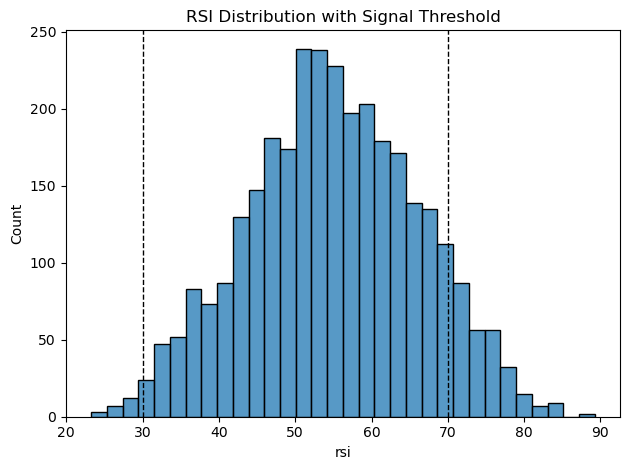

In [20]:
ax = sns.histplot(f.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()
save_fig("RSI_distribution_{}".format(ticker))

### Distribution of bollinger bands

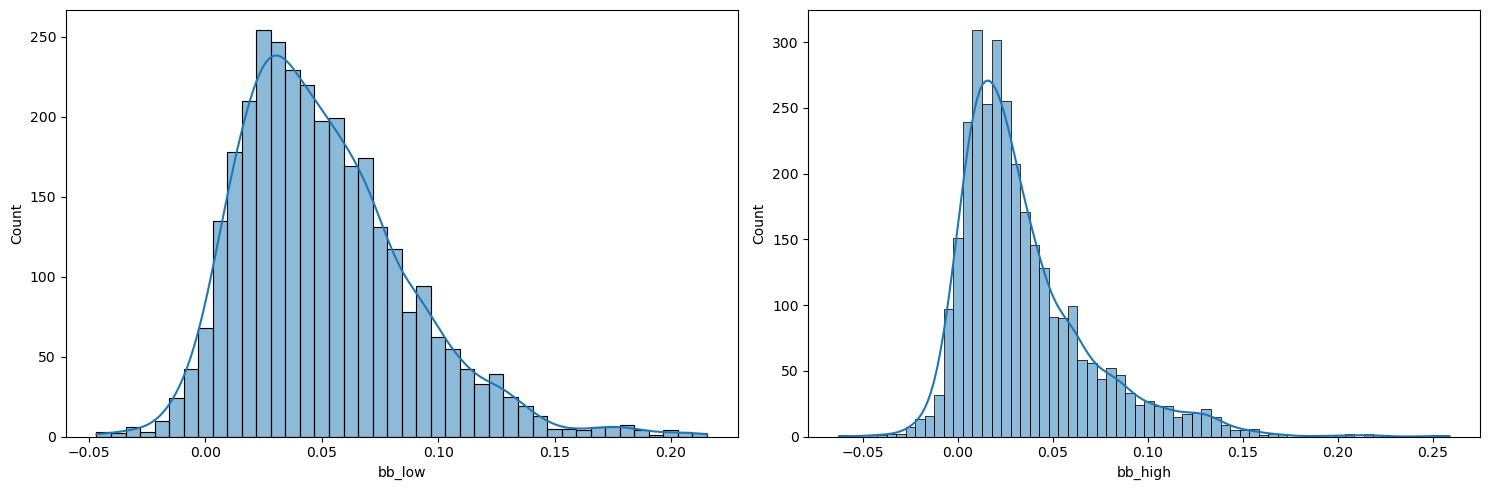

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(f.loc[:, 'bb_low'].dropna(), ax=axes[0], kde=True)
sns.histplot(f.loc[:, 'bb_high'].dropna(), ax=axes[1], kde=True)
plt.tight_layout()
save_fig("bb_bands_{}".format(ticker))

### distribution of  Average True Range

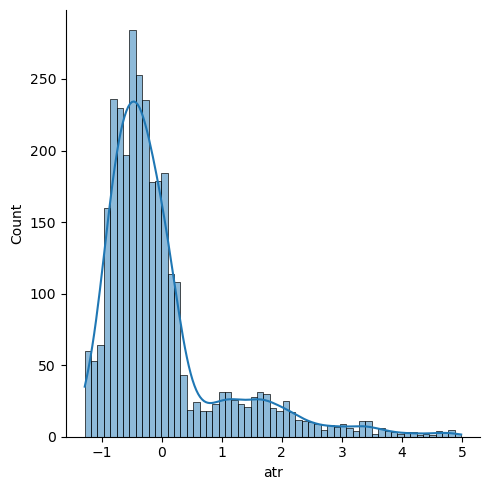

In [23]:
sns.displot(f.atr.dropna(),kde=True)
plt.tight_layout()
save_fig("atr_{}".format(ticker))

### Moving Average Convergence/Divergence

In [191]:
f.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    3,125.0
mean         0.0
std          1.0
min         -4.6
0.1%        -4.4
1%          -3.7
2%          -2.9
3%          -2.5
4%          -2.1
5%          -1.5
50%         -0.1
95%          1.9
96%          2.1
97%          2.4
98%          2.7
99%          2.8
99.9%        4.4
max          4.6
Name: macd, dtype: object

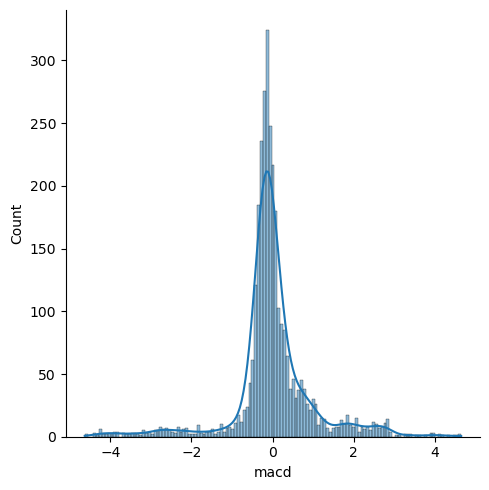

In [24]:
sns.displot(f.macd.dropna(), kde=True)
plt.tight_layout()
save_fig('macd_{}'.format(ticker))

### lagged returns

In [25]:
lags = [1, 5, 10, 21, 42, 63]

In [26]:
returns = f.close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,1.64%
min,-14.74%
0.01%,-13.70%
0.1%,-9.06%
1%,-4.23%
50%,0.07%
99%,4.53%
99.9%,8.98%
99.99%,13.04%
max,14.22%


In [27]:
f.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3125 entries, 2010-07-06 to 2022-11-30
Data columns (total 52 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             3125 non-null   float64
 1   high             3125 non-null   float64
 2   low              3125 non-null   float64
 3   close            3125 non-null   float64
 4   volume           3125 non-null   int64  
 5   rsi              3125 non-null   float64
 6   bb_high          3125 non-null   float64
 7   bb_low           3125 non-null   float64
 8   atr              3125 non-null   float64
 9   macd             3125 non-null   float64
 10  return_1d        3125 non-null   float64
 11  return_5d        3125 non-null   float64
 12  return_10d       3125 non-null   float64
 13  return_21d       3125 non-null   float64
 14  return_42d       3125 non-null   float64
 15  return_63d       3125 non-null   float64
 16  return_1d_lag1   3125 non-null   float64
 